<a href="https://colab.research.google.com/github/stepsbtw/Quantum-Computing-and-Algorithms/blob/main/grovers_ibm_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install 'qiskit[visualization]'
%pip install qiskit-ibm-runtime

# Background
Amplificação de Amplitude é um algoritmo quântico usado para acelerar quadraticamente varios outros algoritmos clássicos.

O **Algoritmo de Grover** foi o primeiro a demonstrar essa melhoria em problemas de busca não-estruturados.

Formular um problema de busca de Grover requere uma função oráculo que marca uma ou mais bases computacionais como estados "desejados" a serem encontrados, e um circuito de amplificação que aumenta a amplitude desses estados marcados, consequentemente diminuindo os estados sobressalentes.

Vamos demonstrar como construir os oráculos de Grover usando a biblioteca de circuitos do Qiskit, para fácilmente configurar uma instancia de busca de Grover.

In [ ]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

## 1. Mapear inputs clássicos para um problema quântico

O algoritmo precisa de um **oráculo** que especifique um ou mais estados bases "marcados", isto é, com fase -1.

Uma porta Controlled-Z, ou sua generalização multi-controlada em $N$ qubits, marca o estado $2^N-1$ (`'1'`*$N$ bit-string).

Marcando estados base com um ou mais `'0'` na representação binária requere aplicar portas X (not) nos qubits correspondentes antes e depois da porta Z-Controlada - o equivalente a ter controle-aberto àquele qubit -.

A porta `MCMT` é usada para implementar o Z multicontrolado.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel="ibm_quantum", token="3981e7d22f4d39cc63502549121a6a235b6046ba68d10db75837923c6144c09c99ce185339920d39b8ff5fbce9720f32cce6430fc4ac45957657c6efc3d311bd")

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

/tmp/ipython-input-20-3518575371.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum")


'ibm_brisbane'

In [ ]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

### Instância específica de Grover:
Agora com a função oráculo, podemos definir uma instância específica da busca de Grover. Nesse exemplo vamos marcar dois estados computacionais dos 8 disponíveis em um espaço computacional de 3-qubits.

/tmp/ipython-input-21-2149212773.py:27: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


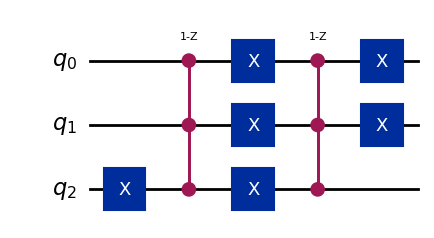

In [ ]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

### GroverOperator
Essa classe pega o circuito de um oráculo e retorna um circuito composto daquele circuito do oráculo E um circuito que amplifica os estados marcados pelo oráculo.

Aqui usamos o `decompose` para ver as portas dentro do operador:

/tmp/ipython-input-23-2665495518.py:1: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op = GroverOperator(oracle)


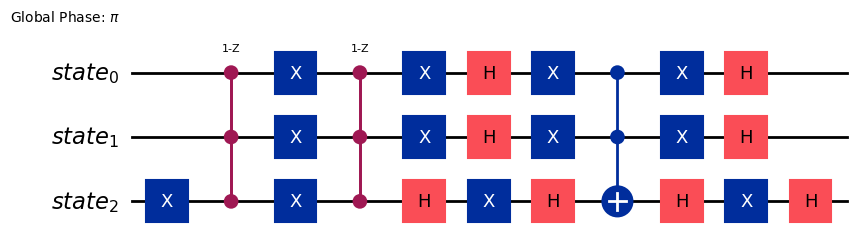

In [ ]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Aplicações repetidas vezes desse circuito `grover_op` amplifica os estados marcados, fazendo com que eles sejam as bit-strings mais prováveis na distribuição de saída do circuito.

Existe um número ótimo para estas aplicações que é determinado pela razão desses estados marcados pelo número total de possíveis estados computacionais:

In [ ]:
optimal_num_iterations = math.floor(math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits))))

### Circuito Completo de Grover
Um experimento completo de Grover começa com uma porta Hadamard em cada qubit, criando uma superposição equivalente de todos os estados base.

Seguido pelo operador de Grover (`grover_op`) repetido o número ótimo de vezes.

Aqui usamos o método `QuantumCircuit.power(INT)` para aplicar repetidamente o operador de Grover.

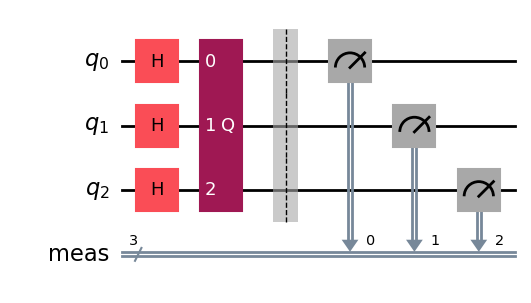

In [ ]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## 2. Otimizar o problema para execução quântica

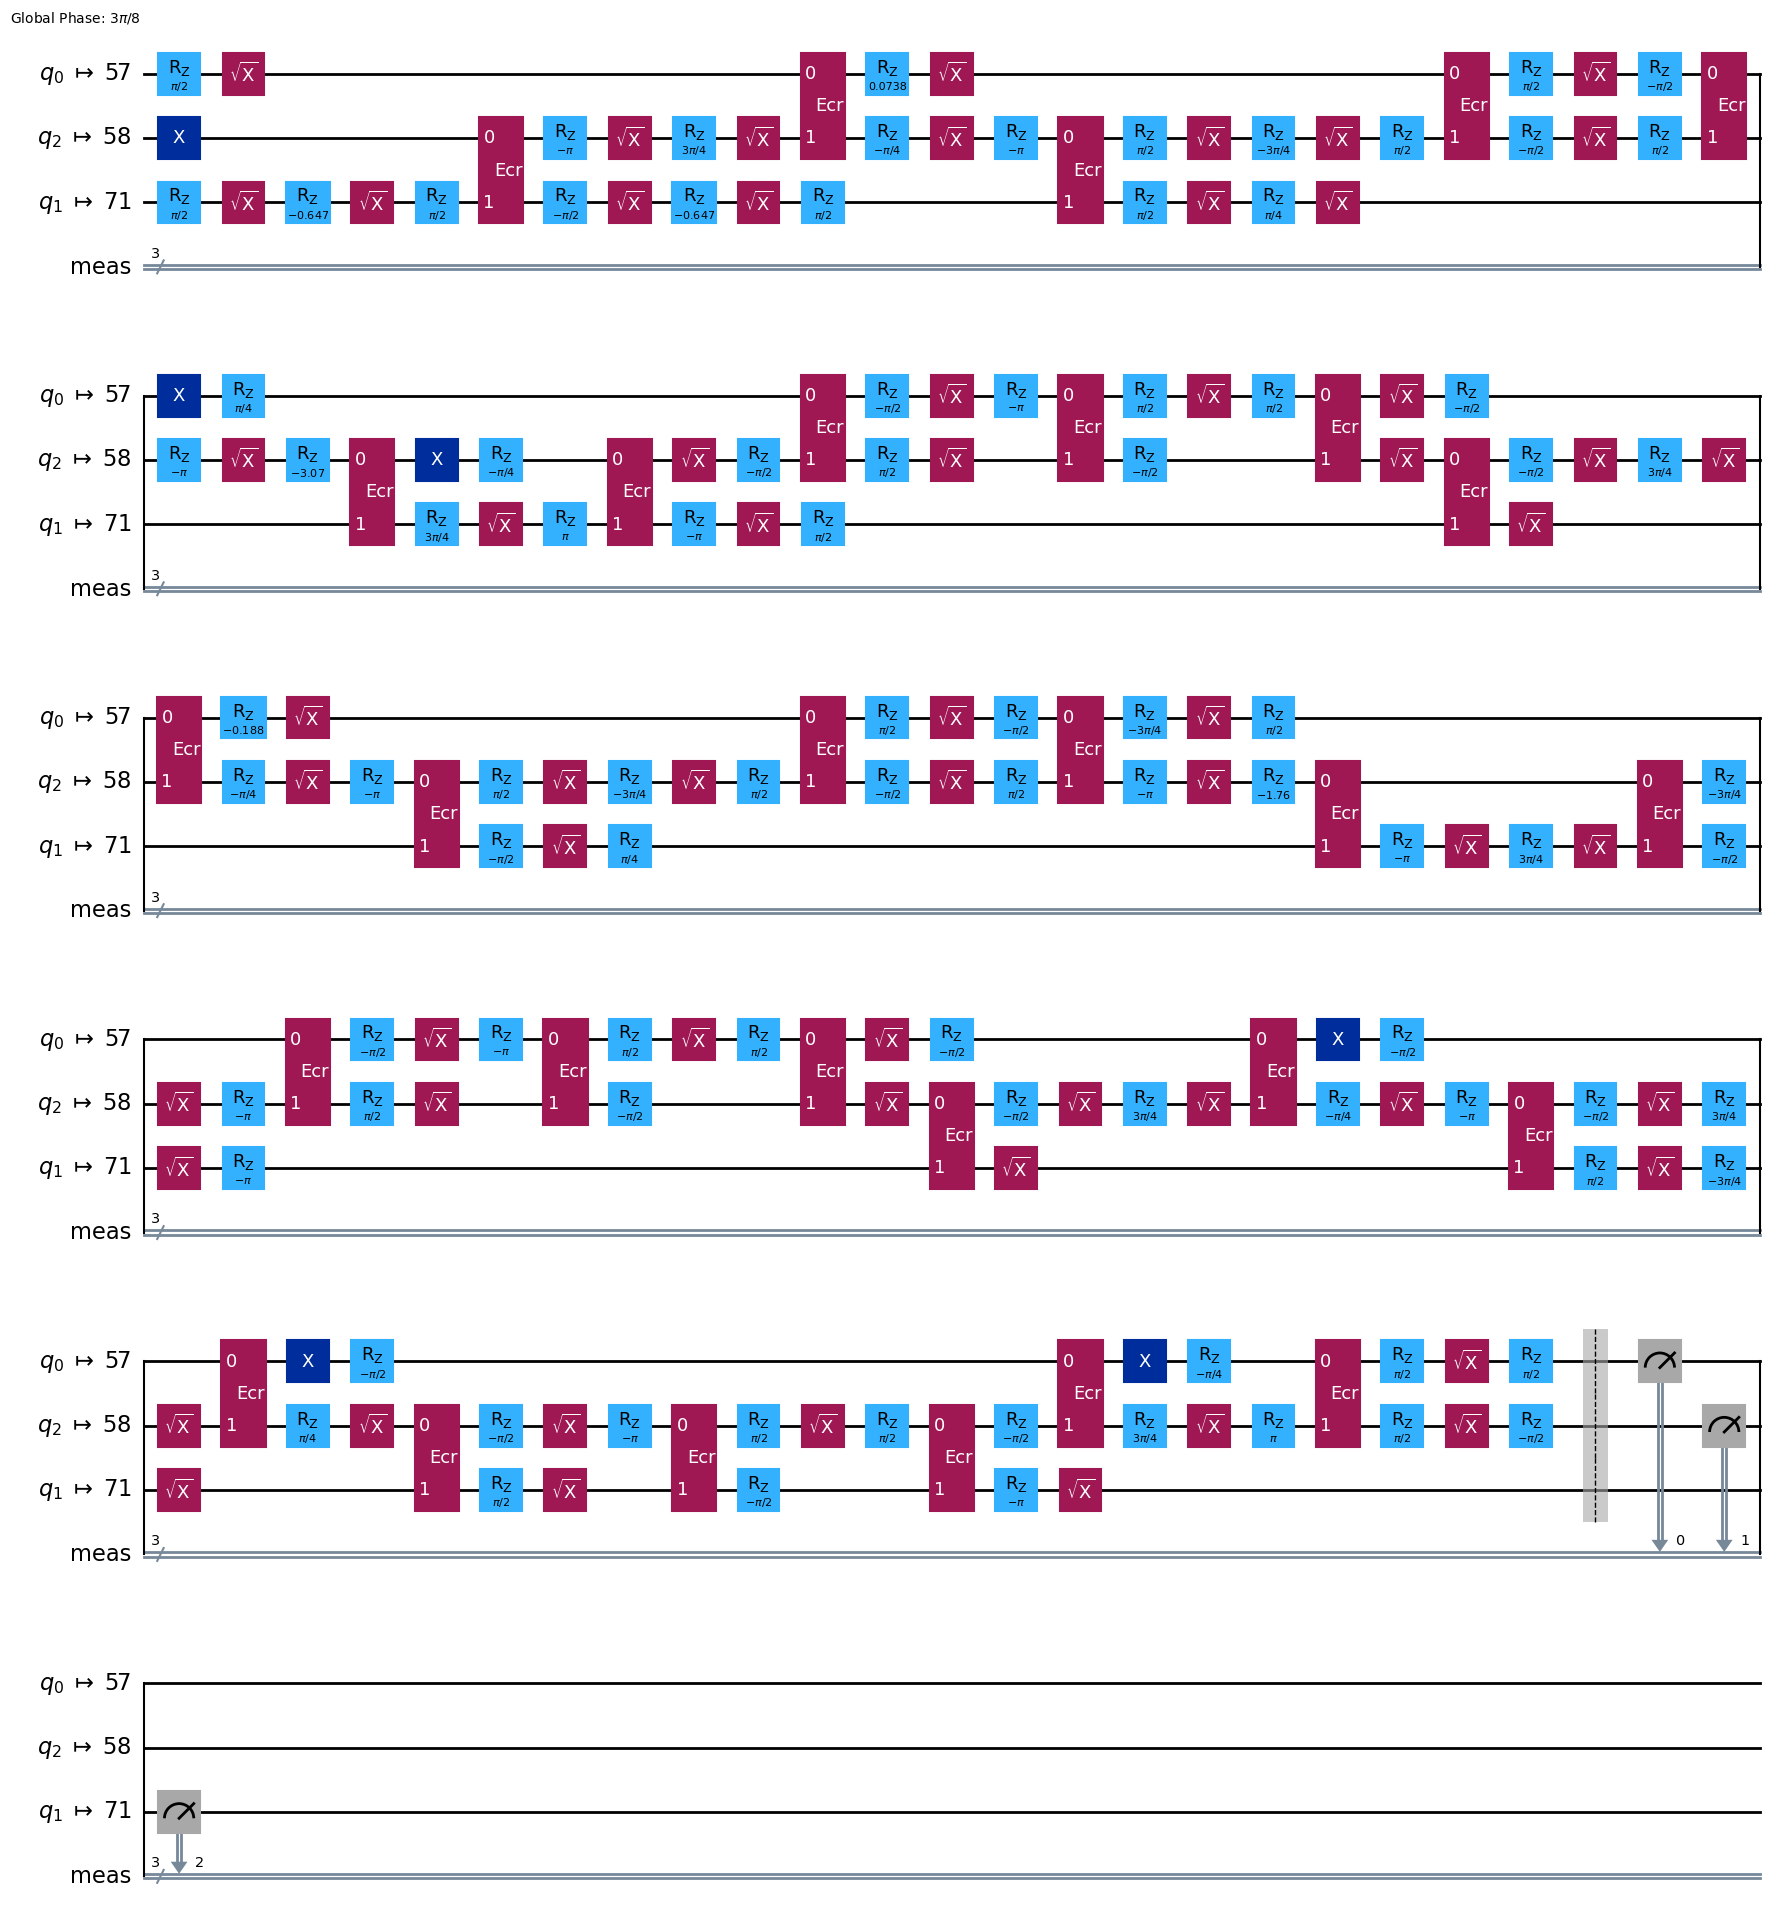

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

# 3. Executar usando as Qiskit Primitives

Amplificação de amplitude é um problema de amostragem que é bom utilizar em conjunto com a primitiva `Sampler` runtime.

In [ ]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

/usr/local/lib/python3.11/dist-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


#4. Saída no formato clássico

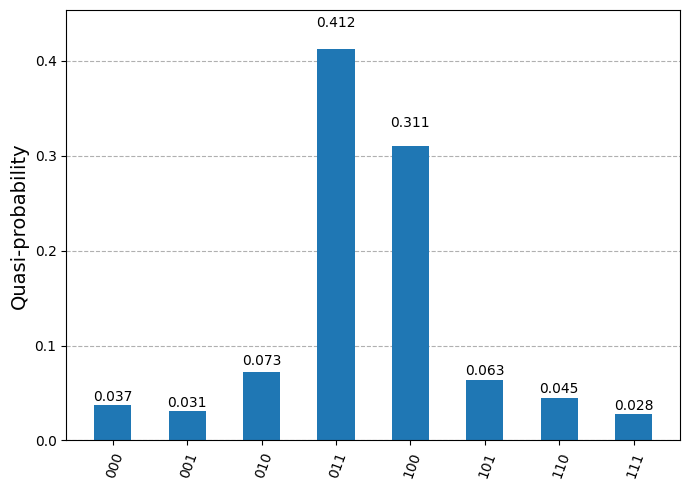

In [ ]:
plot_distribution(dist)